# Imports

In [103]:
import cv2
import os
from astropy.io import fits
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors

# Functions

### Image import

This function imports the images in a single folder and saves them in an array

In [2]:
# Para leer las carpetas
# https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
# Para importar archivos .fits
# https://docs.astropy.org/en/stable/io/fits/

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        # We have to concatenate the folder name with the file name
        hdul = fits.open(folder+filename)
        if hdul[0] is not None:
            images.append(hdul[0].data)
    return images

This function makes an array of arrays, in which each one has the images of a particular exposure time.

In [131]:
def array_images(directory, m_bias, remove_bias):
    images = []
    for folder in os.listdir(directory):
        # For each exposure time, we make an array containing the images
        image_set = load_images_from_folder(directory+folder+"/")
        if remove_bias:
            images.append(image_set - m_bias)
        else:
            images.append(image_set)
    return images
        

## Master Bias

Load master bias

In [119]:
master_bias = np.load('master_bias.npy')





### Phtoton transfer method

This function generates the sets of images to eventually the median and standard deviation images. As each integration image has five images, each integration time is going to have ten images for the average and ten images for the difference. We are going to generate two sets, one for the difference, and one for the average.

This code can be written much more efficiently due to the fact that the each integration time is iterated upon in each function.

In [163]:
def av_and_diff_set(image_set):
    diff_set = []
    av_set = []
    # N: number of images per integration time
    N = len(image_set[1])
    # We go through each integration time.
    # int_index: Integration index
    for int_index in range(len(image_set)):
        # Each integration time is going to have 10 diff and av sets.
        diff_set_aux = []
        av_set_aux = []
        # For an image i, we make sets with the next N-i images.
        for img_index in range(N):
            # Here we work with the next N-i images.
            for i in range(img_index+1, N):
                # Compute the difference and average frames
                difference = image_set[int_index][img_index] - image_set[int_index][i]
                average = (image_set[int_index][img_index] + image_set[int_index][i])/2
                diff_set_aux.append(difference)
                av_set_aux.append(average)
        diff_set.append(diff_set_aux)
        av_set.append(av_set_aux)
    return (diff_set, av_set)

The following function divides the difference and average images into subimages of size MxM and computes the arrays of standar deviation and mean. We are going to assume that M is a factor of 1296.

In [89]:
def std_av_calculation(diff_set, av_set, M):
    std_array = []
    av_array = []
    # N: number of images per integration time
    N = len(diff_set[0])
    # We go through each integration time.
    # int_index: Integration index
    for int_index in range(len(diff_set)):
        # Each integration time is going to add (1296/M)*(1296/M)*10 values in each array (std and mean)
        for img_index in range(N):
            # We are going through each image in a specific integration time
            # Current dif and av images being used
            aux_diff_image = diff_set[int_index][img_index]
            aux_av_image = av_set[int_index][img_index]
            # We are going to use a function that does the subdivision and the calculation of the std and mean
            aux_std_array, aux_av_array = sub_images_std_av(aux_diff_image, aux_av_image, M, img_index, int_index)
            # Now we add these values to the final arrays
            std_array = std_array + aux_std_array
            av_array = av_array + aux_av_array
    # We change the lists into arrays
    std_array = np.array(std_array)
    av_array = np.array(av_array)
    return (std_array, av_array)
    

This function takes two images and returns two arrays that contain std and av of the subdivisions of the image.

In [165]:
def sub_images_std_av(diff_image, av_image, M, img_index_debug, int_index_debug):
    # These arrays have the std and av values of each image
    aux_std_array = []
    aux_av_array = []
    image_size = 1296
    # Now we need to know the ammount of 
    steps = int(image_size/M)
    # We are going trough the image in boxes of size MxM
    for row_index in range(steps):
        for col_index in range(steps):
            # We define the sub images
            sub_diff_image = diff_image[row_index*M: row_index*M + M, col_index*M: col_index*M + M]
            sub_av_image = av_image[row_index*M: row_index*M + M, col_index*M: col_index*M + M]
            # Now we compute the average and std.
            # We have to divide the result of the std by sqrt(2)
            std = np.std(sub_diff_image)/np.sqrt(2)
            mean = np.mean(sub_av_image)
            #if 20000>(std*std)>10000:
                #print('Integration index:', int_index_debug)
                #print('Image index:', img_index_debug)
                #print('Row index:', row_index)
                #print('Column index:', col_index)
            aux_std_array.append(std)
            aux_av_array.append(mean)
    return (aux_std_array, aux_av_array)
            

This is the function that combines the last three functions to return the final arrays for the photon transfer function.

In [134]:
def photon_transfer_arrays(folder_location, M, m_bias, remove_bias):
    # This function imports the images into an array.
    imgs = array_images(folder_location, m_bias, remove_bias)
    # Now we obtain the difference and average image sets
    difference_set, average_set = av_and_diff_set(imgs)
    # Now, we compute the final arrays
    return std_av_calculation(difference_set, average_set, M)
    
    

In [16]:
imgs = array_images("FOWLER/1/")

In [17]:
a, b = av_and_diff_set(imgs)

In [18]:
print(np.shape(b))

(16, 10, 1296, 1296)


In [26]:
y, x = sub_images_std_av(a[13][0],b[13][0],27)

In [166]:
y, x = photon_transfer_arrays("FOWLER/3/", 9, master_bias, False)

In [136]:
print(np.shape(y))
print((1296/27)**2*10*16)

(368640,)
368640.0


In [169]:
y_corr = []
x_corr = []
for i in range(len(x)):
    if (y[i]*y[i])<6000:
        y_corr.append(y[i])
        x_corr.append(x[i])
y_corr = np.array(y_corr)
x_corr = np.array(x_corr)

c:\users\7cg2r\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  


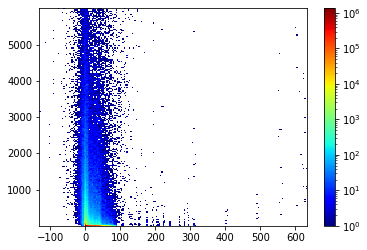

In [170]:
my_cmap = plt.cm.jet
my_cmap.set_under('w',1)
plt.hist2d(x_corr,y_corr*y_corr, norm=matplotlib.colors.LogNorm(), bins=(200, 200),cmap = my_cmap)
plt.colorbar()
plt.show()

In [171]:
p = np.polyfit(x_corr, y_corr*y_corr, 1)
m = p[0]
c = p[1]
print('read_out', 1/m)

gain 6.0362229650778385


In [28]:
print(np.shape(y))
print(48*48)

(2304,)
2304


Integration index: 14
Image index: 5
Row index: 45
Column index: 3

In [99]:
sub_img = a[14][10][45*27 : 45*27+27,3*27 : 3*27+27]
imgplot = plt.imshow(sub_img)
plt.colorbar()
print(np.std(sub_img)**2)

IndexError: list index out of range

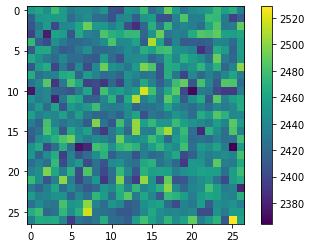

In [9]:
imgplot = plt.imshow(b[13][0][500 : 527,500 : 527])
plt.colorbar()